In [1]:
%matplotlib inline
# imported necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 limit 100000
""", con) 

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'




/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [3]:


#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')



In [4]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [5]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [6]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


positive    73592
negative    14181
Name: Score, dtype: int64

In [9]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [10]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'it', 'under', 'should', 'itself', 'themselves', 'mightn', 'these', 'so', 'than', "it's", 'have', 'few', 'just', "needn't", 'there', 'on', 'his', 'weren', 'needn', 'ours', 'for', 'them', "that'll", "didn't", 'no', 'yourself', 'same', 'having', 'hasn', 'above', 'below', "she's", 'had', 'all', 'won', "mightn't", "weren't", 'more', 'can', 'our', 'into', 'ourselves', 'hers', 'you', 'this', 'were', 'only', 'very', "hadn't", 'by', "shouldn't", 'whom', 't', "couldn't", 'they', 'doesn', 'herself', 'about', 'him', 'who', 'against', 'as', 'being', "doesn't", 'such', 'because', 'don', 'isn', 'its', "shan't", 'through', 'up', 'own', 'wouldn', 'm', 'ain', 'll', 'theirs', 'we', 'a', 'between', 'that', "haven't", 'during', "you're", 'nor', 'once', 'not', 'too', 'at', 'further', 'which', 'he', 'other', "isn't", 'down', 'has', 'me', 'yours', 'of', 'do', 'most', 'will', "hasn't", 'why', 'until', 'couldn', 'when', 'aren', 'your', 'what', 'both', "you've", 'now', 'am', 'then', 'is', "aren't", 'hadn', 'mu

In [11]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [14]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [15]:
cleaned_data.shape

(87773, 12)

In [16]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,b'dog love chicken product china wont buy anym...
1,22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,b'dog love saw pet store tag attach regard mad...
2,70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,negative,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",b'infest fruitfli liter everywher fli around k...
3,70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,negative,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,b'worst product gotten long time would rate st...
4,70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,negative,1306972800,A big rip off,I wish I'd read the reviews before making this...,b'wish read review make purchas basic cardsotc...


In [17]:
cleaned_data["Score"].value_counts()

positive    73592
negative    14181
Name: Score, dtype: int64

In [18]:
# To randomly sample 100k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n =73592)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 14181)
final_100k = pd.concat([data_pos, data_neg])
final_100k.shape

(87773, 12)

In [19]:
final_100k["Time"] = pd.to_datetime(final_100k["Time"], unit = "s")
final_100k = final_100k.sort_values(by = "Time")
final_100k.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
27,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...
40,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
39,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...
493,28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,positive,2003-10-25,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,b'love stuff doesnt rot gum tast good go buy g...
492,28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,positive,2003-10-25,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",b'noth product bother link top page buy use ch...


In [20]:
# Fuction to compute alpha value
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(1, 500, 0.5)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [21]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (87773,)


In [22]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (87773,)


In [23]:
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(61441,) (61441,) (26332,)


In [24]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)

In [25]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [26]:
x_test.shape


(26332, 28910)

In [27]:
X_train.shape

(61441, 28910)

In [28]:
y_train.shape

(61441,)


The optimal number of alpha is 2.


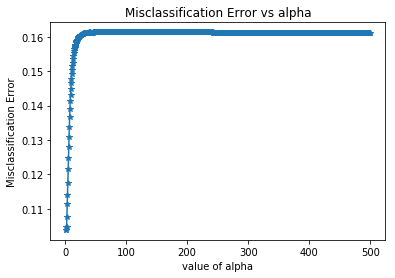

2.0

In [29]:
# To choose optimal_alpha using cross validation
optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [30]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [31]:
bow_features = bow.get_feature_names()

In [32]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 28910)

In [33]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.37842593, -12.37842593, -11.97296083, ..., -12.37842593,
        -11.97296083, -12.37842593],
       [-13.41410819, -13.41410819, -13.81957329, ..., -13.41410819,
        -13.81957329, -13.41410819]])

In [35]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(28910, 2)

In [36]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -4.351602
like      -4.396010
product   -4.590214
one       -4.868817
flavor    -4.928928
would     -5.007251
tri       -5.023104
coffe     -5.180242
good      -5.185116
use       -5.217192
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -4.396382
tast      -4.529683
good      -4.640672
flavor    -4.665856
love      -4.673238
great     -4.745568
one       -4.797190
use       -4.851496
product   -4.913519
tri       -4.914400
Name: 1, dtype: float64


In [37]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.9111179831057438


In [38]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.088882%


In [39]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))


The accuracy of the naive bayes classifier for alpha = 2 is 89.799484%


In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2303,  1981],
       [  705, 21343]])

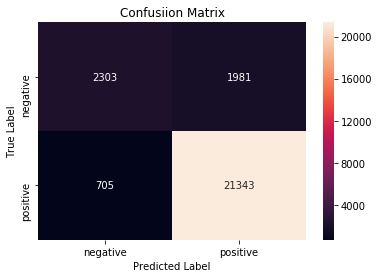

In [41]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.77      0.54      0.63      4284
   positive       0.92      0.97      0.94     22048

avg / total       0.89      0.90      0.89     26332



In [43]:
# data
X = final_100k["CleanedText"]

In [44]:


# Target/class-label
y = final_100k["Score"]



In [45]:


# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)



(61441,) (26332,) (61441,) (26332,)


In [46]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data


#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
#tf_idf_vect= TfidfVectorizer(ngram_range=(1,2))

#tf_idf_vect=dfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()

#X_train = tf_idf_vect.fit_transform(X_train)
#X_Train=CountVectorizer(ngram_range=(1,2) )
#y_train.shape


from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<61441x880457 sparse matrix of type '<class 'numpy.float64'>'
	with 4195791 stored elements in Compressed Sparse Row format>

In [47]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(26332, 880457)


The optimal number of alpha is 1.


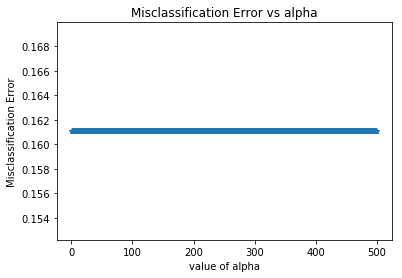

1.0

In [48]:
# To choosing optimal_alpha

optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

In [49]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = nb_optimal.predict(x_test)

In [50]:
tfidf_features = tf_idf_vect.get_feature_names()

In [51]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 880457)

In [52]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([ 9897., 51544.])

In [53]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-13.76836668, -13.76836668, -13.76836668, ..., -13.69337726,
        -13.76836668, -13.76836668],
       [-13.84840316, -13.94859625, -13.94859625, ..., -14.03332427,
        -13.84633352, -13.84633352]])

In [54]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape


(880457, 2)

In [55]:
# To show top 10 feature from both class
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])


Top 10 negative features:-
 tast      -8.501350
like      -8.626910
product   -8.679034
coffe     -8.982810
would     -8.997776
flavor    -9.010899
one       -9.042890
tri       -9.120780
buy       -9.177550
dog       -9.210748
Name: 0, dtype: float64


 Top 10 positive features:-
 love      -7.398619
great     -7.412810
like      -7.432268
good      -7.460337
coffe     -7.462494
tast      -7.465064
flavor    -7.518704
tea       -7.544066
product   -7.677303
one       -7.713408
Name: 1, dtype: float64


In [56]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.8389837404990154


In [57]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.161016%


In [58]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, acc_tfidf))


The accuracy of the naive bayes classifier for alpha = 1 is 83.730822%


In [59]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[    0,  4284],
       [    0, 22048]])

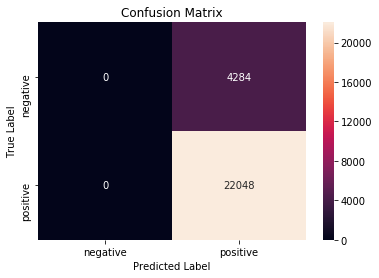

In [60]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      4284
   positive       0.84      1.00      0.91     22048

avg / total       0.70      0.84      0.76     26332



/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

Automatically created module for IPython interactive environment


In [90]:
n_classes = y.shape

In [87]:
n_classes

(87773, 1)

In [66]:
random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(x_test)



In [238]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y = label_binarize(y, classes=[0, 1])
n_classes = y_tst.shape[1]
n_classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_tst1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


    

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [242]:
roc_curve

<function sklearn.metrics.ranking.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)>

TypeError: float() argument must be a string or a number, not 'dict'

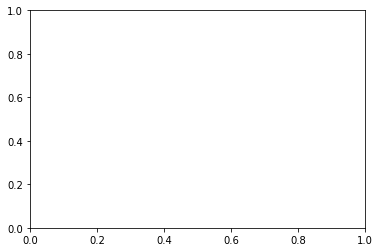

In [241]:
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(roc_auc)
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [201]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: Data is not binary and pos_label is not specified

In [204]:
y_tst=label_binarize(y, classes=['negative', 'positive'])
y_tst

/home/dtewani/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [181]:
y_test[:2]

47402    negative
1749     positive
Name: Score, dtype: object

In [82]:
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]
n_classes

1

In [166]:
y_test[2:1]

Series([], Name: Score, dtype: object)

In [170]:
 y_score

array([[0.35704122],
       [1.91392392],
       [0.01626686],
       ...,
       [1.58388515],
       [1.38132817],
       [0.0268154 ]])

In [109]:
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]
n_classes

1

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = # ground truth labels
y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [205]:
#roc_curve(y_tst, y_score)

y_tst1=y_tst[:26332]
y_tst1

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [189]:
y_score.shape

(26332, 1)

In [190]:
pd.DataFrame({'noc':np.random.randint(10, size=15)})

AttributeError: module 'numpy.random' has no attribute 'y_tst'

In [145]:
gona = np.array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

#gona[1,:]
#array([4, 5, 6])

#gona[:,1]
#array([ 2,  5,  8, 11])

gona[:,0]
#array([ 1,  4,  7, 10])

array([ 1,  4,  7, 10])

In [196]:
roc_curve(y_tst1, y_score)



/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


(array([0.00000000e+00, 3.79766064e-05, 3.13307003e-02, 3.14066535e-02,
        9.44478201e-02, 9.45237734e-02, 1.10511925e-01, 1.10587878e-01,
        3.34232113e-01, 3.34308066e-01, 6.39905818e-01, 6.40019748e-01,
        6.52210238e-01, 6.52286192e-01, 8.24851891e-01, 8.24927844e-01,
        9.85151147e-01, 9.85227100e-01, 1.00000000e+00]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan]),
 array([ 5.4157733 ,  4.4157733 ,  2.61515724,  2.61491018,  2.23668976,
         2.23645566,  2.17336309,  2.17324685,  1.62873262,  1.62865209,
         0.99993466,  0.99989979,  0.96836371,  0.96833975,  0.33868982,
         0.33849176, -1.59357345, -1.59395448, -4.25196092]))

/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/dtewani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


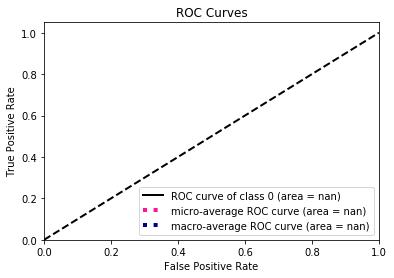

In [246]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_tst1, y_score)